<a href="https://colab.research.google.com/github/prithuls/MultiviewSegmentation-CvAM/blob/main/2%2C_Big_Mass_MultiViewUNet_CvAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import os, glob, cv2
from skimage.io import imsave
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, concatenate, \
              Conv2D, Add, MaxPooling2D, Activation, add, \
              Conv2DTranspose, BatchNormalization, Reshape, \
              GlobalAveragePooling2D, Multiply, Dense, \
              Permute, Multiply, Lambda, concatenate, \
              GlobalMaxPool2D, AveragePooling2D
from tensorflow.keras.optimizers import Adam, SGD, Adadelta, Adagrad
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
#from data import load_train_data, load_test_data
from sklearn.model_selection import train_test_split
K.set_image_data_format('channels_last')
from scipy.spatial.distance import directed_hausdorff

In [ ]:
## Configuration

train_full_dir = "/content/gdrive/MyDrive/CS791MassDetectionOnMammograms/Data(CBIS-DDSM)/processed/mass-train-full"
train_mask_combined_dir = "/content/gdrive/MyDrive/CS791MassDetectionOnMammograms/Data(CBIS-DDSM)/processed/mass-train-mask-combined"
test_full_dir = "/content/gdrive/MyDrive/CS791MassDetectionOnMammograms/Data(CBIS-DDSM)/processed/mass-test-full"
test_mask_combined_dir = "/content/gdrive/MyDrive/CS791MassDetectionOnMammograms/Data(CBIS-DDSM)/processed/mass-test-mask-combined"
extension = ".png"

target_size = 256

brightness_delta = 0.3

batch_size = 8
smooth = 1.

encoder_input_shape = (target_size, target_size, 3)
decoder_kernel_size = (3, 3)
decoder_strides = (2, 2)
decoder_padding = 'same'
decoder_activation = None
final_layer_filters = 1
final_layer_activation = "sigmoid"
learning_rate = 0.0001

## **Preprocessing**

###Preprocessing of Multi-View Images

In [ ]:
def datasetPaths(full_img_dir, mask_img_dir, extension):

    """
    Follows the flow:
    1.         datasetPaths() *
              _______|_______
            |               |
    2. loadFullImg()  loadMaskImg()
            |_______________|
                    |
    3.          tfParse()
                    |
    4.         imgAugment()
                    |
    5.        makeTFDataset()
    Takes in the directories of the folder containing the full mammogram
    scans (x) and the ground truth masks (y) and returns a list of paths to
    individual full scans and masks.
    Parameters
    ----------
    full_img_dir : {str}
        Directory that contains the FULL training images.
    mask_img_dir : {str}
        Directory that contains the MASK training images.
    extension : {str}
        The file extension of the images (e.g. ".png")
    Returns
    -------
    x_paths_list: {list}
        A list of paths to individual FULL images in the training set.
    y_paths_list: {list}
        A list of paths to individual MASK images in the training set.
    """

    try:

        # =======================================
        #  1. Get paths of X (full) and y (mask)
        # =======================================

        x_paths_list = []
        y_paths_list = []

        full_img_ID = [fn[:26] for fn in sorted(os.listdir(full_img_dir))]
        mask_img_ID = [fn[:26] for fn in sorted(os.listdir(mask_img_dir))]

        full_dirs = [fn for fn in sorted(os.listdir(full_img_dir))]
        mask_dirs = [fn for fn in sorted(os.listdir(mask_img_dir))]

        ## Common Elements
        common_ID_FullandMask = []
        temp_mask_img_ID = mask_img_ID
        for a_ in full_img_ID:
          for b_ in temp_mask_img_ID:
            if a_ == b_:
              common_ID_FullandMask.append(a_)
              temp_mask_img_ID.remove(b_)

        temp_full_path, temp_mask_path = 0, 0 ## For checking if the 'Below function ifs' are picking anything

        for i in range(len(common_ID_FullandMask)):
            for j in range(len(full_dirs)):
                fn_ = full_dirs[j]
                if common_ID_FullandMask[i] in fn_ and fn_.endswith(extension):
                    temp_full_path = fn_
                    break
            for k in range(len(mask_dirs)):
                fn_2 = mask_dirs[k]
                if common_ID_FullandMask[i] in fn_2 and fn_2.endswith(extension) :
                    temp_mask_path = fn_2
                    break
            if temp_full_path == 0 or temp_mask_path == 0:
                temp_full_path, temp_mask_path = 0, 0
                continue
            
            full_dirs.pop(j)
            mask_dirs.pop(k)
            x_paths_list.append(os.path.join(full_img_dir, temp_full_path))
            y_paths_list.append(os.path.join(mask_img_dir, temp_mask_path))

            temp_full_path, temp_mask_path = 0, 0 # Reasserting value to 0


        print('x_paths_list length', len(x_paths_list))
        print('y_paths_list length', len(y_paths_list))


        # Get paths of train images and masks.
        '''for full in os.listdir(full_img_dir):
            if full.endswith(extension):
                x_paths_list.append(os.path.join(full_img_dir, full))

        for mask in os.listdir(mask_img_dir):
            if mask.endswith(extension):
                y_paths_list.append(os.path.join(mask_img_dir, mask))'''

        # ** IMPORTANT ** Sort so that FULL and MASK images are in an order
        # that corresponds with each other.
        #x_paths_list.sort()
        #y_paths_list.sort()

    except Exception as e:
        # logger.error(f'Unable to datasetPaths!\n{e}')
        print((f"Unable to datasetPaths!\n{e}"))

    return x_paths_list, y_paths_list


def create_dict(full_dir, mask_combined_dir):
    full_img_files = sorted(os.listdir(full_dir))
    mask_img_files = sorted(os.listdir(mask_combined_dir))

    if "train" in full_dir:
        str_start, str_end = 16, 27
    elif "test" in full_dir:
        str_start, str_end = 12, 23

    hm_files = {}
    for f1, f2 in zip(full_img_files, mask_img_files):
        temp_key = f1[str_start : str_end]    ## Key is the patient id and left/right breast
        if temp_key not in hm_files:
            hm_files[temp_key] = [[], []]
        hm_files[temp_key][0].append(os.path.join(full_dir, f1))
        hm_files[temp_key][1].append(os.path.join(mask_combined_dir, f2))

    # for key in hm_files:
    #     print(key, hm_files[key])

    count = 0
    keys_to_pop = []
    for key in hm_files:
        if len(hm_files[key][0]) == 1:
            keys_to_pop.append(key)
            count += 1

    print("Before popping, number of keys to pop with length 1: ", count, " and total length: ", len(hm_files.keys()))

    for key in keys_to_pop:
        hm_files.pop(key, None)

    ## To check if the dictionary has any key with length 1
    count = 0
    for key in hm_files:
        if len(hm_files[key][0]) == 1:
            count += 1
            # print(key)

    print("After popping, number of keys to pop with length 1: ", count)
    print("After popping, number of keys with length 2: ", len(hm_files.keys()))

    return hm_files

def loadFullImg(path, dsize):

    """
    Takes in the path of a FULL image and loads it as a grayscale image (as
    a numpy array with 3 channels).
    Parameters
    ----------
    path : {str}
        The path of the FULL image.
    Returns
    -------
    full_img : {numpy.ndarray}
        The loaded image with shape = (self.target_size, self.target_size, 3)
    """

    try:
        # =====================================
        #  2a. Read images (full)
        # =====================================
        # if not isinstance(path, str):
        #     path = path.decode()

        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(src=img, dsize=(dsize, dsize))

        # Min max normalise to [0, 1].
        norm_img = (img - img.min()) / (img.max() - img.min())

        # Stack grayscale image to make channels=3.
        full_img = np.stack([norm_img, norm_img, norm_img], axis=-1)

    except Exception as e:
        # logger.error(f'Unable to loadFullImg!\n{e}')
        print((f"Unable to loadFullImg!\n{e}"))

    return full_img

def loadMaskImg(path, dsize):

    """
    Takes in the path of a MASK image and loads it as a grayscale image (as
    a numpy array with 1 channel).
    Parameters
    ----------
    path : {str}
        The path of the MASK image.
    Returns
    -------
    full_img : {numpy.ndarray}
        The loaded image with shape = (self.target_size, self.target_size, 1)
    """

    try:

        # ========================
        #  2b. Read images (mask)
        # ========================
        # if not isinstance(path, str):
        #     path = path.decode()

        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(src=img, dsize=(dsize,dsize))

        # Min max normalise to [0, 1].
        norm_img = (img - img.min()) / (img.max() - img.min())

        # Expand shape to (width, height, 1).
        mask_img = np.expand_dims(norm_img, axis=-1)

        
        return mask_img

    except Exception as e:
        # logger.error(f'Unable to loadMaskImg!\n{e}')
        print((f"Unable to loadMaskImg!\n{e}"))


def tfParse(img_cc_path, img_mlo_path, mask_cc_path, mask_mlo_path):

    """
    Takes in a FULL image path and a MASK image path, loads the images using
    loadFullImg() and loadMaskImg() and makes it TensorFlow executable.
    Parameters
    ----------
    x_path: {str}
        The path of the FULL image to be loaded.
    y_path: {str}
        The path of the MASK image to be loaded.
    Returns
    -------
    x : {tensor}
        The FULL image loaded as a tensor with shape =
        (self.target_size, self.target_size, 3)
    y : {tensor}
        The MASK image loaded as a tensor with shape =
        (self.target_size, self.target_size, 1)
    """

    def _parse(x_path, y_path):
        x = loadFullImg(path=x_path, dsize=target_size)
        y = loadMaskImg(path=y_path, dsize=target_size)
        return x, y

    try:
        # ===========
        #  3. Parse
        # ===========

        # x_cc, y_cc = tf.numpy_function(_parse, [img_cc_path, mask_cc_path], [tf.float64, tf.float64])
        # x_mlo, y_mlo = tf.numpy_function(_parse, [img_mlo_path, mask_mlo_path], [tf.float64, tf.float64])

        x_cc, y_cc = _parse(img_cc_path, mask_cc_path)
        x_mlo, y_mlo = _parse(img_mlo_path, mask_mlo_path)

        print(type(y_cc[0][0][0]))

        y_cc = (y_cc > 0.5 ) * 1.0
        y_mlo = (y_mlo > 0.5 ) * 1.0

        print(type(y_cc[0][0][0]))

        y_cc = tf.cast(y_cc, tf.float32)
        y_mlo = tf.cast(y_mlo, tf.float32)

        print(type(y_cc[0][0][0]))

        print(np.shape(x_cc), np.shape(y_cc))




        # x_cc.set_shape([target_size, target_size, 3])
        # x_mlo.set_shape([target_size, target_size, 3])
        # y_cc.set_shape([target_size, target_size, 1])
        # y_mlo.set_shape([target_size, target_size, 1])

        x = concatenate([x_cc, x_mlo], axis = -1)
        y = concatenate([y_cc, y_mlo], axis = -1)

        ## temp - for getting the unique values
        unique_counts_cc = np.unique(y_cc, return_counts= True)
        unique_counts_mlo = np.unique(y_mlo, return_counts= True)
        # print("Y CC", unique_counts_cc[1][1])
        # print("Y MLO", unique_counts_mlo[1][1])

        if unique_counts_cc[1][1] + unique_counts_mlo[1][1] < 600:
            return False


        return x, y

    except Exception as e:
        # logger.error(f'Unable to tfParse!\n{e}')
        print((f"Unable to tfParse!\n{e}"))

def imgAugment(x_img, y_img):

    """
    Apply random image augmentation to full mammogram scans (x_img). Note
    that the same augmentation has to be applied to the masks (y_img), apart
    from the brightness augmentation.
    Parameters
    ----------
    x_img : {numpy.ndarray}
        Full mammogram scan to augment.
    y_img : {numpy.ndarray}
        Corresponding mask of `x_img`.
    Returns
    -------
    x_img : {numpy.ndarray}
        Augmented x_img.
    y_img : {numpy.ndarray}
        Augmented y_img.
    """

    try:

        # =========
        #  LR Flip
        # =========
        # Generate random number from uniform distribution
        # in the range [0.0, 1.0)
        if tf.random.uniform(()) > 0.5:
            x_img = tf.image.flip_left_right(image=x_img)
            y_img = tf.image.flip_left_right(image=y_img)

        # =========
        #  UD Flip
        # =========
        if tf.random.uniform(()) > 0.5:
            x_img = tf.image.flip_up_down(image=x_img)
            y_img = tf.image.flip_up_down(image=y_img)

        # ============
        #  Brightness
        # ============
        # Only change the brightness of x_img, not y_img!
        x_img = tf.image.random_brightness(
            image=x_img, max_delta= brightness_delta
        )

    except Exception as e:
        # logger.error(f'Unable to imgAugment!\n{e}')
        print((f"Unable to imgAugment!\n{e}"))

    return x_img, y_img

def makeTFDataset(shuffle, augment, x_paths_list, y_paths_list, batch_size):

    """
    Takes in a FULL image path and a MASK image path, loads the images using
    loadFullImg() and loadMaskImg() and makes it TensorFlow executable.
    Parameters
    ----------
    shuffle : {boolean}
        If True, shuffle dataset. Should only shuffle train set.
    augment : {boolean}
        If True, perform augmentation. Should only augment test set.
    x_paths_list : {list}
        The path of the FULL image to be loaded.
    y_paths_list : {list}
        The path of the MASK image to be loaded.
    batch_size : {int}
        The batch size to create the dataset with.
    Returns
    -------
    ds : {RepeatDataset}
        The dataset with x (FULL) and y (MASK) images loaded from
        `x_paths_list` and `y_paths_list`.
        For each `batch` in `ds`:
        - type = tuple
        - len = 2
        - `batch[0]` (this is a batch of the FULL images):
            - type = tensorflow.python.fraework.ops.EagerTensor
            - shape = (self.batch_size, self.target_size, self.target_size, 3)
            - `batch[0][0]` (this is the first FULL image in the batch):
                - type = tensorflow.python.fraework.ops.EagerTensor
                - shape = (self.target_size, self.target_size, 3)
        - `batch[1]` (this is a batch the MASK images):
            - type = tensorflow.python.fraework.ops.EagerTensor
            - shape = (self.batch_size, self.target_size, self.target_size, 1)
                - `batch[1][0]` (this is the first MASK image in the batch):
                - type = tensorflow.python.fraework.ops.EagerTensor
                - shape = (self.target_size, self.target_size, 1)
    """

    try:
        # ====================
        #  4. Make TF Dataset
        # ====================

        ds = tf.data.Dataset.from_tensor_slices((x_paths_list, y_paths_list))

        # Shuffle the paths of the elements
        # with buffer_size=len(x_paths_list), since storing all the paths
        # in memory will not be an issue (as compared to storing all the
        # imported images as tensors).
        if shuffle:
            ds = ds.shuffle(buffer_size=len(x_paths_list))

        # Transform paths to images after shuffling the paths.
        ds = ds.map(tfParse, num_parallel_calls=tf.data.experimental.AUTOTUNE)

        # Apply image augmentation.
        if augment:
            ds = ds.map(
                imgAugment, num_parallel_calls=tf.data.experimental.AUTOTUNE
            )

        # Batch only AFTER shuffle, so that we shuffled the elements not the batches.
        ds = ds.batch(batch_size=batch_size, drop_remainder=False)
        ds = ds.repeat()  # We need to repeat in order to train for > 1 epoch.

    except Exception as e:
        # logger.error(f'Unable to makeTFDataset!\n{e}')
        print((f"Unable to makeTFDataset!\n{e}"))

    return ds

In [ ]:
hm_train_files_multi_view = create_dict(train_full_dir, train_mask_combined_dir)
hm_test_files_multi_view = create_dict(test_full_dir, test_mask_combined_dir)

Before popping, number of keys to pop with length 1:  213  and total length:  722
After popping, number of keys to pop with length 1:  0
After popping, number of keys with length 2:  509
Before popping, number of keys to pop with length 1:  59  and total length:  211
After popping, number of keys to pop with length 1:  0
After popping, number of keys with length 2:  152


In [ ]:
X_train, y_train = [], []

for key in hm_train_files_multi_view:
    img_cc_path, img_mlo_path = sorted(hm_train_files_multi_view[key][0])
    mask_cc_path, mask_mlo_path = sorted(hm_train_files_multi_view[key][1])
    try:
        _false = tfParse(img_cc_path, img_mlo_path, mask_cc_path, mask_mlo_path)
        if not _false:
            continue
        X_train.append(_false[0])
        y_train.append(_false[1])
    except Exception as e:
        print("Appending issue: ", e)

In [ ]:
X_test, y_test = [], []

for key in hm_test_files_multi_view:
    img_cc_path, img_mlo_path = sorted(hm_test_files_multi_view[key][0])
    mask_cc_path, mask_mlo_path = sorted(hm_test_files_multi_view[key][1])

    try:
        _false = tfParse(img_cc_path, img_mlo_path, mask_cc_path, mask_mlo_path)
        if not _false:
            continue
        X_test.append(_false[0])
        y_test.append(_false[1])
    except Exception as e:
        print("Appending issue: ", e)

In [ ]:
np.shape(X_test)

(41, 256, 256, 6)

In [ ]:
np.shape(y_train)

(121, 256, 256, 2)

In [ ]:
np.save("/content/gdrive/MyDrive/CS791MassDetectionOnMammograms/Data(CBIS-DDSM)/processed/X_train_mass_greater_than_300.npy", X_train, allow_pickle=False)
np.save("/content/gdrive/MyDrive/CS791MassDetectionOnMammograms/Data(CBIS-DDSM)/processed/y_train_mass_greater_than_300.npy", y_train, allow_pickle=False)
np.save("/content/gdrive/MyDrive/CS791MassDetectionOnMammograms/Data(CBIS-DDSM)/processed/X_test_mass_greater_than_300.npy", X_test, allow_pickle=False)
np.save("/content/gdrive/MyDrive/CS791MassDetectionOnMammograms/Data(CBIS-DDSM)/processed/y_test_mass_greater_than_300.npy", y_test, allow_pickle=False)

In [ ]:
np.shape(y_train[0])

TensorShape([256, 256, 2])

In [ ]:
np.unique(y_train[0], return_counts= True)

(array([0, 1]), array([130371,    701]))

### Loading npy files

In [ ]:
X_train = np.load("/content/gdrive/MyDrive/CS791MassDetectionOnMammograms/Data(CBIS-DDSM)/processed/X_train.npy")
y_train = np.load("/content/gdrive/MyDrive/CS791MassDetectionOnMammograms/Data(CBIS-DDSM)/processed/y_train.npy")
X_test = np.load("/content/gdrive/MyDrive/CS791MassDetectionOnMammograms/Data(CBIS-DDSM)/processed/X_test.npy")
y_test = np.load("/content/gdrive/MyDrive/CS791MassDetectionOnMammograms/Data(CBIS-DDSM)/processed/y_test.npy")

### Loading Big Mass npy files

In [ ]:
X_train = np.load("/content/gdrive/MyDrive/CS791MassDetectionOnMammograms/Data(CBIS-DDSM)/processed/X_train_mass_greater_than_100.npy")
y_train = np.load("/content/gdrive/MyDrive/CS791MassDetectionOnMammograms/Data(CBIS-DDSM)/processed/y_train_mass_greater_than_100.npy")
X_test = np.load("/content/gdrive/MyDrive/CS791MassDetectionOnMammograms/Data(CBIS-DDSM)/processed/X_test_mass_greater_than_100.npy")
y_test = np.load("/content/gdrive/MyDrive/CS791MassDetectionOnMammograms/Data(CBIS-DDSM)/processed/y_test_mass_greater_than_100.npy")

###Creating tf dataset

In [ ]:
val_size = int(len(X_train) * 0.08)
train_size = len(X_train) - val_size

In [ ]:
train_ds_whole = tf.data.Dataset.from_tensor_slices((X_train, y_train))

train_ds = train_ds_whole.take(train_size)
val_ds = train_ds_whole.skip(train_size).take(val_size)

test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))

In [ ]:
print("Train size: ", len(train_ds))
print("Val size: ", len(val_ds))
print("Test size: ", len(test_ds))

Train size:  112
Val size:  9
Test size:  41


In [ ]:
train_ds = train_ds.shuffle(train_size).batch(batch_size)
val_ds = val_ds.shuffle(val_size).batch(batch_size)

test_ds = test_ds.batch(batch_size)

## **Metrics**

In [ ]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    
# def dice(pred, true, k = 1):
#     intersection = np.sum(pred[true==k]) * 2.0
#     dice = intersection / (np.sum(pred) + np.sum(true))
#     return dice

# def iou(pred, true, k = 1):
#     intersection = np.sum(pred[true==k])
#     iou = intersection / (np.sum(pred) + np.sum(true) - intersection)
#     return iou

def iou_coef(y_true, y_pred, smooth=1):
  intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
  union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
  iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
  return iou

def jacard(y_true, y_pred):

    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum ( y_true_f * y_pred_f)
    union = K.sum ( y_true_f + y_pred_f - y_true_f * y_pred_f)

    return intersection/union

def sens(y_true, y_pred):
    num=K.sum(K.multiply(y_true, y_pred))
    denom=K.sum(y_true)
    if denom==0:
        return 1
    else:
        return  num/denom

def spec(y_true, y_pred):
    num=K.sum(K.multiply(y_true==0, y_pred==0))
    denom=K.sum(y_true==0)
    if denom==0:
        return 1
    else:
        return  num/denom

def tversky(y_true, y_pred):
    y_true_pos = K.flatten(y_true)
    y_pred_pos = K.flatten(y_pred)
    true_pos = K.sum(y_true_pos * y_pred_pos)
    false_neg = K.sum(y_true_pos * (1-y_pred_pos))
    false_pos = K.sum((1-y_true_pos)*y_pred_pos)
    alpha = 0.7
    return (true_pos + smooth)/(true_pos + alpha*false_neg + (1-alpha)*false_pos + smooth)

def focal_tversky(y_true,y_pred):
    pt_1 = tversky(y_true, y_pred)
    gamma = 0.75
    return K.pow((1-pt_1), gamma)


## From TDS guy

def iouMetric(y_true, y_pred):

      """
      Calculates the intersection-over-union between a ground truth mask and
      the corresponding predicted mask from the model.
      Parameters
      ----------
      y_true : {tf.Tensor}
          The ground truth mask.
      y_pred : {tf.Tensor}
          Corresponding predicted mask.
      Returns
      -------
      compute_iou() : {tf.numpy_function}
          A function that calculates the IOU metric.
      """

      try:

          def compute_iou(y_true, y_pred):
              intersection = (y_true * y_pred).sum()
              union = y_true.sum() + y_pred.sum() - intersection
              x = (intersection + 1e-15) / (union + 1e-15)
              x = x.astype(np.float32)
              return x

          return tf.numpy_function(compute_iou, [y_true, y_pred], tf.float32)

      except Exception as e:
          # logger.error(f'Unable to iouMetric!\n{e}')
          print((f"Unable to iouMetric!\n{e}"))

## **Loss**

In [ ]:
def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def modified_loss(y_true, y_pred):
    return -(0.4*dice_coef(y_true, y_pred)+0.6*iou_coef(y_true, y_pred))

## **CvAM with Basic U-Net**

![Architecture1.png](https://i.imgur.com/YeZ3KPH.png)

In [ ]:
def cvam_spatial_attention(x_cc,x_mlo):
    avg_pool_cc = tf.reduce_mean(x_cc, axis= [3], keepdims= True)
    max_pool_cc = tf.reduce_max(x_cc, axis=[3], keepdims=True)

    avg_pool_mlo = tf.reduce_mean(x_mlo, axis= [3], keepdims= True)
    max_pool_mlo = tf.reduce_max(x_mlo, axis=[3], keepdims=True)

    concat = concatenate([avg_pool_cc, max_pool_cc, avg_pool_mlo, max_pool_mlo], axis = -1)
    cvam_spatial_feature = Conv2D(4, (3, 3), padding="same")(concat)
    cvam_spatial_feature = Activation('relu')(cvam_spatial_feature)
    cvam_spatial_feature = Conv2D(1, (3, 3), padding="same")(cvam_spatial_feature)
    cvam_spatial_feature = Activation('sigmoid')(cvam_spatial_feature)

    x_cvam_cc_spatial, x_cvam_mlo_spatial = Multiply()([x_cc, cvam_spatial_feature]), Multiply()([x_mlo, cvam_spatial_feature])
    return x_cvam_cc_spatial, x_cvam_mlo_spatial

In [ ]:
def cvam_channel_attention(x_cc, x_mlo, ratio=8):
    features=[x_cc, x_mlo]
    channel = x_cc.shape[-1]	
    shared_layer_one = Dense(channel//ratio,
                activation='relu',
                kernel_initializer='he_normal',
                use_bias=True,
                bias_initializer='zeros')
    shared_layer_two = Dense(channel,
                kernel_initializer='he_normal',
                use_bias=True,
                bias_initializer='zeros')

    avg_pool_cc = tf.reduce_mean(x_cc, axis= [-2, -3], keepdims= True)
    avg_pool_cc = shared_layer_one(avg_pool_cc)
    avg_pool_cc = shared_layer_two(avg_pool_cc)

    max_pool_cc = tf.reduce_max(x_cc, axis= [-2, -3], keepdims= True)
    max_pool_cc = shared_layer_one(max_pool_cc)
    max_pool_cc = shared_layer_two(max_pool_cc)

    avg_pool_mlo = tf.reduce_mean(x_mlo, axis= [-2, -3], keepdims= True)
    avg_pool_mlo = shared_layer_one(avg_pool_mlo)
    avg_pool_mlo = shared_layer_two(avg_pool_mlo)

    max_pool_mlo = tf.reduce_max(x_mlo, axis= [-2, -3], keepdims= True)
    max_pool_mlo = shared_layer_one(max_pool_mlo)
    max_pool_mlo = shared_layer_two(max_pool_mlo)

    concat = concatenate([avg_pool_cc, max_pool_cc, avg_pool_mlo, max_pool_mlo], axis= -1)
    cvam_channel_feature = Dense(x_cc.shape[-1])(concat)
    cvam_channel_feature = Activation('sigmoid')(cvam_channel_feature)
    x_cvam_cc_channel, x_cvam_mlo_channel = Multiply()([x_cc, cvam_channel_feature]), Multiply()([x_mlo, cvam_channel_feature])
    
    return x_cvam_cc_channel, x_cvam_mlo_channel

Some possible issues:


*   CvAM Channel and Spatial attention uses axis = 3
*   CBAM paper mentions 1 hidden layer for channel attention



In [ ]:
def cvamBlock(x_cc, x_mlo, ratio = 8):
    ## First goes through spatial attention
    x_cc_s, x_mlo_s = cvam_spatial_attention(x_cc, x_mlo)
    ## Second goes through channel attention
    x_cc_c, x_mlo_c = cvam_channel_attention(x_cc, x_mlo)

    x_cc, x_mlo = tf.multiply(x_cc_s, x_cc_c), tf.multiply(x_mlo_s, x_mlo_c)

    return x_cc, x_mlo

![UNet-with-CvAM](https://i.imgur.com/XFKEWBB.png)

In [ ]:
def unet_with_cvam():
    inputs = Input((target_size, target_size, 6))

    ## Splitting the inputs into cc and mlo

    input_cc = inputs[:, :, :, : 3]
    input_mlo = inputs[:, :, :, 3 :]

    ## 1st Layer

    conv1_cc = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer= tf.keras.regularizers.l2(l=0.001))(input_cc)
    conv1_cc = BatchNormalization()(conv1_cc)
    conv1_cc = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer= tf.keras.regularizers.l2(l=0.001))(conv1_cc)
    conv1_cc = BatchNormalization()(conv1_cc)

    conv1_mlo = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer= tf.keras.regularizers.l2(l=0.001))(input_mlo)
    conv1_mlo = BatchNormalization()(conv1_mlo)
    conv1_mlo = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer= tf.keras.regularizers.l2(l=0.001))(conv1_mlo)
    conv1_mlo = BatchNormalization()(conv1_mlo)

    pool1_cc = MaxPooling2D((2,2), padding='same')(conv1_cc)
    pool1_mlo = MaxPooling2D((2,2), padding='same')(conv1_mlo)

    ## 2nd Layer

    conv2_cc = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer= tf.keras.regularizers.l2(l=0.001))(pool1_cc)
    conv2_cc = BatchNormalization()(conv2_cc)
    conv2_cc = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer= tf.keras.regularizers.l2(l=0.001))(conv2_cc)
    conv2_cc = BatchNormalization()(conv2_cc)

    conv2_mlo = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer= tf.keras.regularizers.l2(l=0.001))(pool1_mlo)
    conv2_mlo = BatchNormalization()(conv2_mlo)
    conv2_mlo = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer= tf.keras.regularizers.l2(l=0.001))(conv2_mlo)
    conv2_mlo = BatchNormalization()(conv2_mlo)

    # conv2_cc, conv2_mlo = cvamBlock(conv2_cc, conv2_mlo)

    pool2_cc = MaxPooling2D((2,2), padding='same')(conv2_cc)
    pool2_mlo = MaxPooling2D((2,2), padding='same')(conv2_mlo)

    ## 3rd Layer

    conv3_cc = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer= tf.keras.regularizers.l2(l=0.001))(pool2_cc)
    conv3_cc = BatchNormalization()(conv3_cc)
    conv3_cc = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer= tf.keras.regularizers.l2(l=0.001))(conv3_cc)
    conv3_cc = BatchNormalization()(conv3_cc)

    conv3_mlo = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer= tf.keras.regularizers.l2(l=0.001))(pool2_mlo)
    conv3_mlo = BatchNormalization()(conv3_mlo)
    conv3_mlo = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer= tf.keras.regularizers.l2(l=0.001))(conv3_mlo)
    conv3_mlo = BatchNormalization()(conv3_mlo)

    # conv3_cc, conv3_mlo = cvamBlock(conv3_cc, conv3_mlo)

    pool3_cc = MaxPooling2D((2,2), padding='same')(conv3_cc)
    pool3_mlo = MaxPooling2D((2,2), padding='same')(conv3_mlo)


    ## 4th Layer

    conv4_cc = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer= tf.keras.regularizers.l2(l=0.001))(pool3_cc)
    conv4_cc = BatchNormalization()(conv4_cc)
    conv4_cc = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer= tf.keras.regularizers.l2(l=0.001))(conv4_cc)
    conv4_cc = BatchNormalization()(conv4_cc)

    conv4_mlo = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer= tf.keras.regularizers.l2(l=0.001))(pool3_mlo)
    conv4_mlo = BatchNormalization()(conv4_mlo)
    conv4_mlo = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer= tf.keras.regularizers.l2(l=0.001))(conv4_mlo)
    conv4_mlo = BatchNormalization()(conv4_mlo)

    # conv4_cc, conv4_mlo = cvamBlock(conv4_cc, conv4_mlo)

    pool4_cc = MaxPooling2D((2,2), padding='same')(conv4_cc)
    pool4_mlo = MaxPooling2D((2,2), padding='same')(conv4_mlo)

    ## 5th Layer

    conv5_cc = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer= tf.keras.regularizers.l2(l=0.001))(pool4_cc)
    conv5_cc = BatchNormalization()(conv5_cc)
    conv5_cc = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer= tf.keras.regularizers.l2(l=0.001))(conv5_cc)
    conv5_cc = BatchNormalization()(conv5_cc)

    conv5_mlo = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer= tf.keras.regularizers.l2(l=0.001))(pool4_mlo)
    conv5_mlo = BatchNormalization()(conv5_mlo)
    conv5_mlo = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer= tf.keras.regularizers.l2(l=0.001))(conv5_mlo)
    conv5_mlo = BatchNormalization()(conv5_mlo)

    ## 6th Layer

    up6_cc = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same', kernel_regularizer= tf.keras.regularizers.l2(l=0.001))(conv5_cc), conv4_cc], axis=3)
    conv6_cc = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer= tf.keras.regularizers.l2(l=0.001))(up6_cc)
    conv6_cc = BatchNormalization()(conv6_cc)
    conv6_cc = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer= tf.keras.regularizers.l2(l=0.001))(conv6_cc)
    conv6_cc = BatchNormalization()(conv6_cc)

    up6_mlo = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same', kernel_regularizer= tf.keras.regularizers.l2(l=0.001))(conv5_mlo), conv4_mlo], axis=3)
    conv6_mlo = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer= tf.keras.regularizers.l2(l=0.001))(up6_mlo)
    conv6_mlo = BatchNormalization()(conv6_mlo)
    conv6_mlo = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer= tf.keras.regularizers.l2(l=0.001))(conv6_mlo)
    conv6_mlo = BatchNormalization()(conv6_mlo)

    conv6_cc, conv6_mlo = cvamBlock(conv6_cc, conv6_mlo)

    ## 7th Layer
    
    up7_cc = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same', kernel_regularizer= tf.keras.regularizers.l2(l=0.001))(conv6_cc), conv3_cc], axis=3)
    conv7_cc = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer= tf.keras.regularizers.l2(l=0.001))(up7_cc)
    conv7_cc = BatchNormalization()(conv7_cc)
    conv7_cc = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer= tf.keras.regularizers.l2(l=0.001))(conv7_cc)
    conv7_cc = BatchNormalization()(conv7_cc)

    up7_mlo = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same', kernel_regularizer= tf.keras.regularizers.l2(l=0.001))(conv6_mlo), conv3_mlo], axis=3)
    conv7_mlo = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer= tf.keras.regularizers.l2(l=0.001))(up7_mlo)
    conv7_mlo = BatchNormalization()(conv7_mlo)
    conv7_mlo = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer= tf.keras.regularizers.l2(l=0.001))(conv7_mlo)
    conv7_mlo = BatchNormalization()(conv7_mlo)

    conv7_cc, conv7_mlo = cvamBlock(conv7_cc, conv7_mlo)

    ## 8th Layer

    up8_cc = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same', kernel_regularizer= tf.keras.regularizers.l2(l=0.001))(conv7_cc), conv2_cc], axis=3)
    conv8_cc = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer= tf.keras.regularizers.l2(l=0.001))(up8_cc)
    conv8_cc = BatchNormalization()(conv8_cc)
    conv8_cc = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer= tf.keras.regularizers.l2(l=0.001))(conv8_cc)
    conv8_cc = BatchNormalization()(conv8_cc)

    up8_mlo = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same', kernel_regularizer= tf.keras.regularizers.l2(l=0.001))(conv7_mlo), conv2_mlo], axis=3)
    conv8_mlo = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer= tf.keras.regularizers.l2(l=0.001))(up8_mlo)
    conv8_mlo = BatchNormalization()(conv8_mlo)
    conv8_mlo = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer= tf.keras.regularizers.l2(l=0.001))(conv8_mlo)
    conv8_mlo = BatchNormalization()(conv8_mlo)

    conv8_cc, conv8_mlo = cvamBlock(conv8_cc, conv8_mlo)

    ## 9th Layer
    
    up9_cc = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same', kernel_regularizer= tf.keras.regularizers.l2(l=0.001))(conv8_cc), conv1_cc], axis=3)
    conv9_cc = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer= tf.keras.regularizers.l2(l=0.001))(up9_cc)
    conv9_cc = BatchNormalization()(conv9_cc)
    conv9_cc = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer= tf.keras.regularizers.l2(l=0.001))(conv9_cc)
    conv9_cc = BatchNormalization()(conv9_cc)

    up9_mlo = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same', kernel_regularizer= tf.keras.regularizers.l2(l=0.001))(conv8_mlo), conv1_mlo], axis=3)
    conv9_mlo = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer= tf.keras.regularizers.l2(l=0.001))(up9_mlo)
    conv9_mlo = BatchNormalization()(conv9_mlo)
    conv9_mlo = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer= tf.keras.regularizers.l2(l=0.001))(conv9_mlo)
    conv9_mlo = BatchNormalization()(conv9_mlo)

    ## Final Layer
        
    conv10_cc = Conv2D(1, (1, 1), activation='sigmoid')(conv9_cc)
    conv10_mlo = Conv2D(1, (1, 1), activation='sigmoid')(conv9_mlo)

    ## Stacking the final masks on top of another
    conv10 = concatenate([conv10_cc, conv10_mlo], axis= -1)


    model = Model(inputs=[inputs], outputs=[conv10])
    model.compile(optimizer = Adam(1e-4), loss = modified_loss, metrics = [dice_coef, jacard, 'accuracy'])
    model.summary()
    return model

In [ ]:
unet_cvam = unet_with_cvam()

In [ ]:
unet_cvam.compile(optimizer = Adam(1e-5), loss = modified_loss, metrics = [dice_coef, jacard, 'accuracy'])

In [ ]:
unet_cvam.load_weights('/content/unet_cvam_epoch_200_dice_0.69-iou_0.54_parallel_modified_loss-big-mass.hdf5')

In [ ]:
train_steps = train_size // batch_size
val_steps =  val_size // batch_size
# test_steps = len(test_x) // batch_size

if train_size % batch_size != 0:
    train_steps += 1
if val_size % batch_size != 0:
    val_steps += 1
# if len(test_x) % batch_size != 0:
#     test_steps += 1


fname = "unet_cvam_epoch_{epoch:02d}_dice_{val_dice_coef:.2f}-iou_{val_jacard:.2f}_parallel_modified_loss-big-mass.hdf5"
model_checkpoint = ModelCheckpoint(fname, monitor='val_loss', save_best_only=False)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=15, verbose=1, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)
early_S = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=25)

print('-'*30)
print('Fitting unet_cvam...')
print('-'*30)


history = unet_cvam.fit(train_ds,
                    validation_data=val_ds,
                    epochs=200,
                    steps_per_epoch=train_steps,
                    validation_steps=val_steps,
                    callbacks=[model_checkpoint, reduce_lr, early_S],
                    verbose=1,
                )   

------------------------------
Fitting unet_cvam...
------------------------------
Epoch 1/200
14/14 [==============================] - 18s 671ms/step - loss: -0.5251 - dice_coef: 0.9151 - jacard: 0.8439 - accuracy: 0.3580 - val_loss: -0.1503 - val_dice_coef: 0.5615 - val_jacard: 0.3912 - val_accuracy: 0.8493 - lr: 1.0000e-05
Epoch 2/200
14/14 [==============================] - 7s 536ms/step - loss: -0.5271 - dice_coef: 0.9165 - jacard: 0.8463 - accuracy: 0.4885 - val_loss: -0.1355 - val_dice_coef: 0.5538 - val_jacard: 0.3834 - val_accuracy: 0.7977 - lr: 1.0000e-05
Epoch 3/200
14/14 [==============================] - 8s 545ms/step - loss: -0.5298 - dice_coef: 0.9188 - jacard: 0.8501 - accuracy: 0.4985 - val_loss: -0.1473 - val_dice_coef: 0.5551 - val_jacard: 0.3851 - val_accuracy: 0.8511 - lr: 1.0000e-05
Epoch 4/200
14/14 [==============================] - 8s 547ms/step - loss: -0.5323 - dice_coef: 0.9197 - jacard: 0.8519 - accuracy: 0.4671 - val_loss: -0.1557 - val_dice_coef: 0.5395 -

In [ ]:
unet_cvam.load_weights("/content/unet_cvam_epoch_200_dice_0.03-iou_0.02_parallel_modified_loss-big-mass.hdf5")

In [ ]:
unet_cvam.compile(optimizer = Adam(1e-4), loss = 'binary_crossentropy', metrics = [dice_coef, jacard, 'accuracy'])

In [ ]:
unet_cvam.evaluate(test_ds)

6/6 [==============================] - 1s 109ms/step - loss: 0.1912 - dice_coef: 0.2290 - jacard: 0.1585 - accuracy: 0.3050


[0.19118718802928925,
 0.22898145020008087,
 0.1584683507680893,
 0.3049863576889038]

In [ ]:
unet_cvam.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 256, 256, 6  0           []                               
                                )]                                                                
                                                                                                  
 tf.__operators__.getitem_4 (Sl  (None, 256, 256, 3)  0          ['input_3[0][0]']                
 icingOpLambda)                                                                                   
                                                                                                  
 tf.__operators__.getitem_5 (Sl  (None, 256, 256, 3)  0          ['input_3[0][0]']                
 icingOpLambda)                                                                             

In [ ]:
#Test

test_masks_squeezed = np.squeeze(test_masks, axis = -1)
predicted_outputs_squeezed = np.squeeze(predicted_outputs, axis = -1)
predicted_outputs_squeezed = np.array(predicted_outputs_squeezed, dtype=np.float64)

In [ ]:
np.shape(y_test)

(41, 256, 256, 2)

In [ ]:
predicted_outputs = unet_cvam.predict(test_ds)

6/6 [==============================] - 3s 117ms/step


In [ ]:
np.shape(X_test[0])

TensorShape([256, 256, 6])

In [ ]:
np.shape(predicted_outputs)

(41, 256, 256, 2)

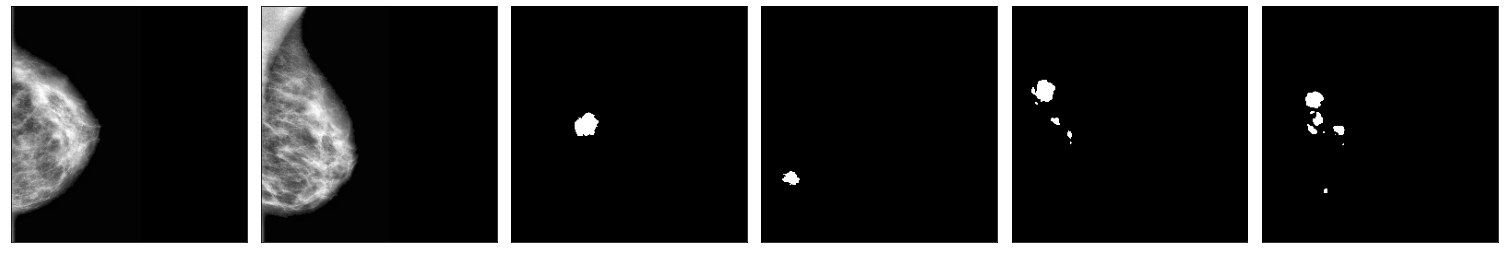

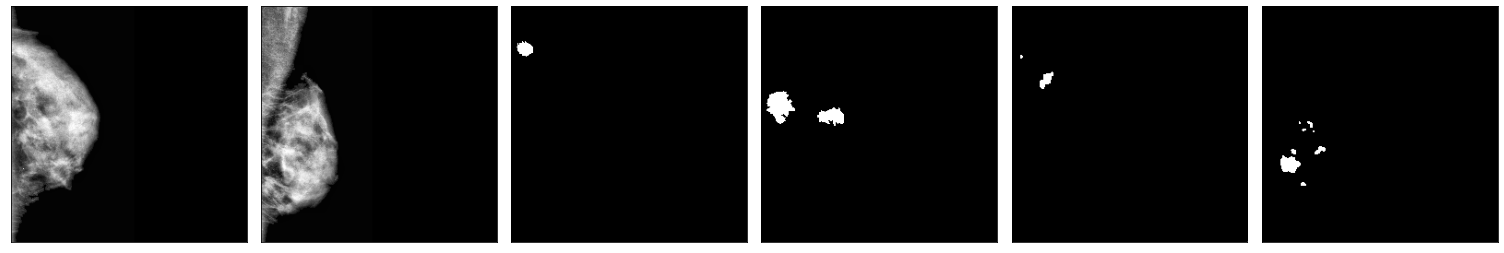

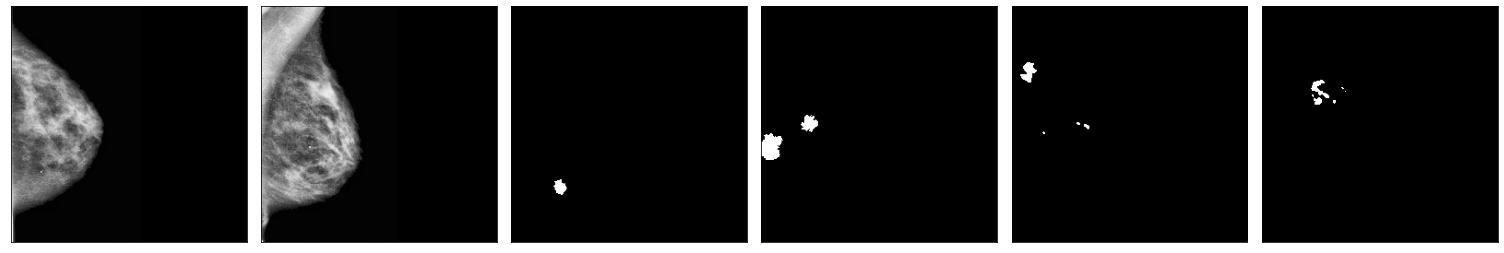

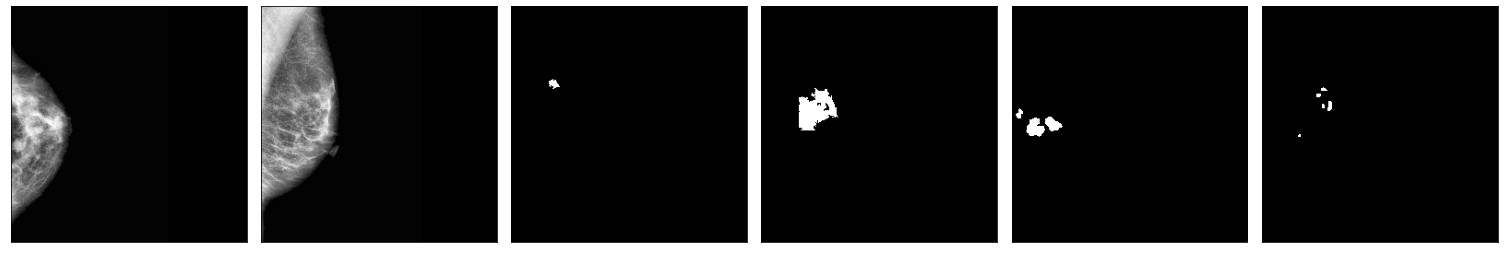

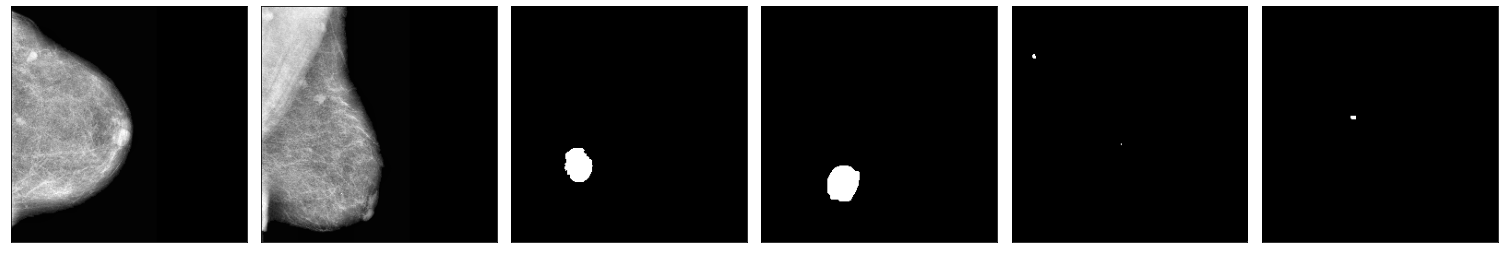

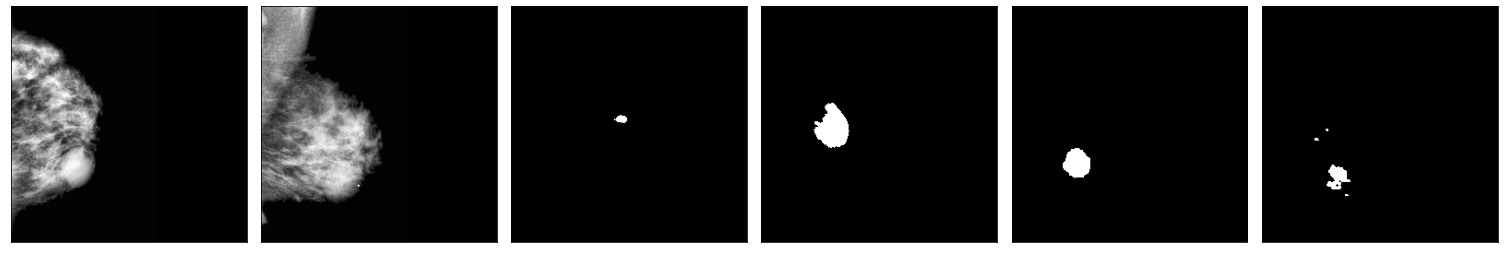

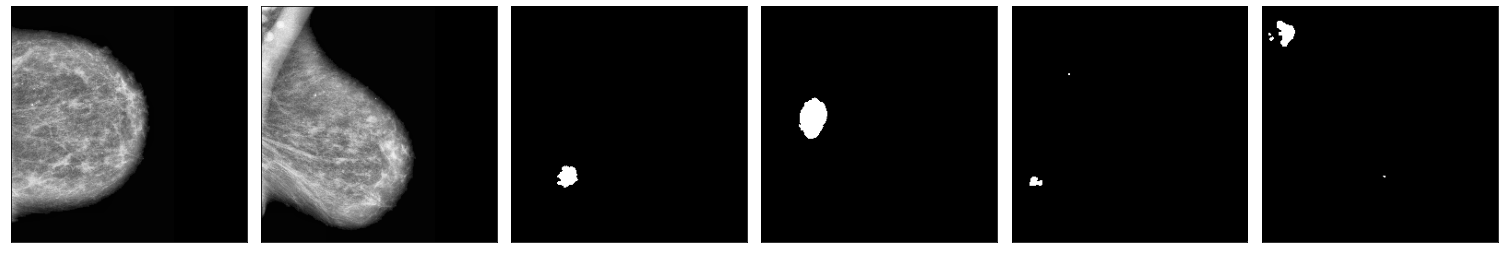

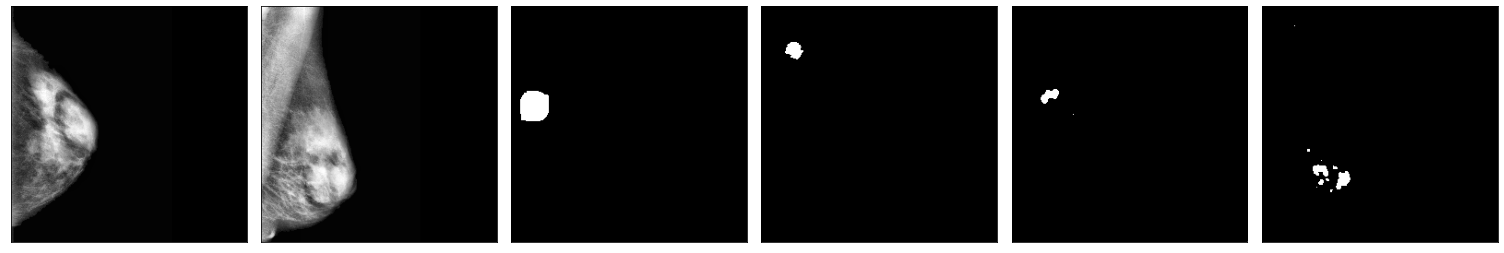

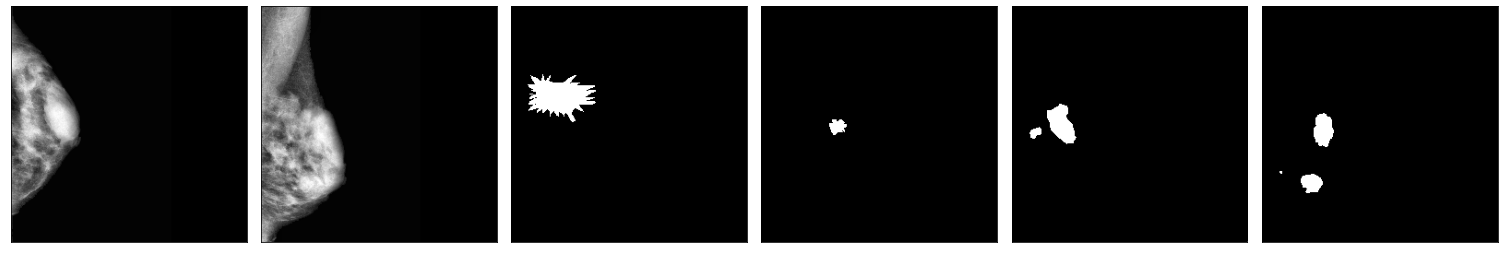

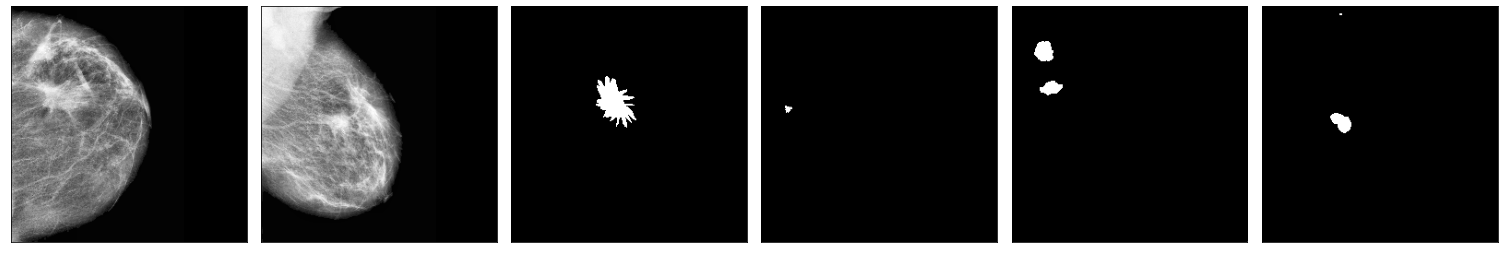

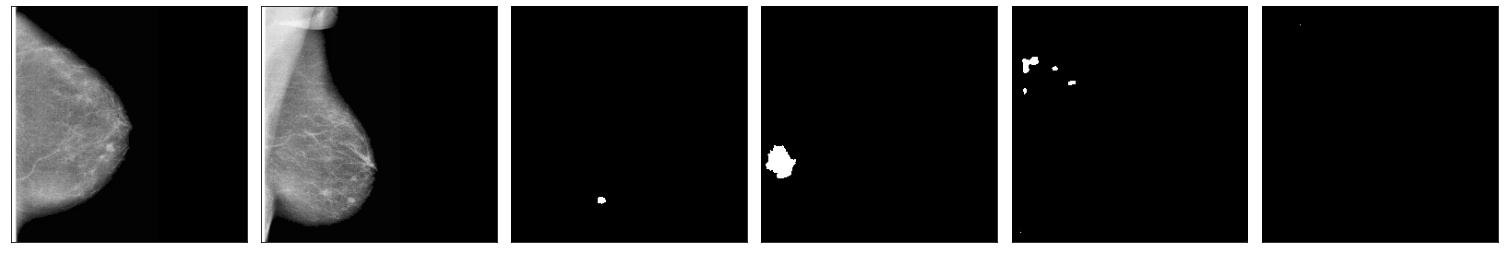

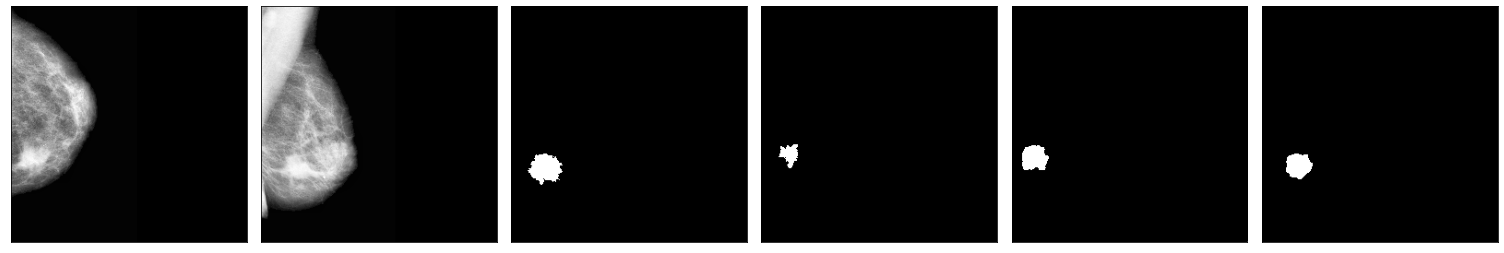

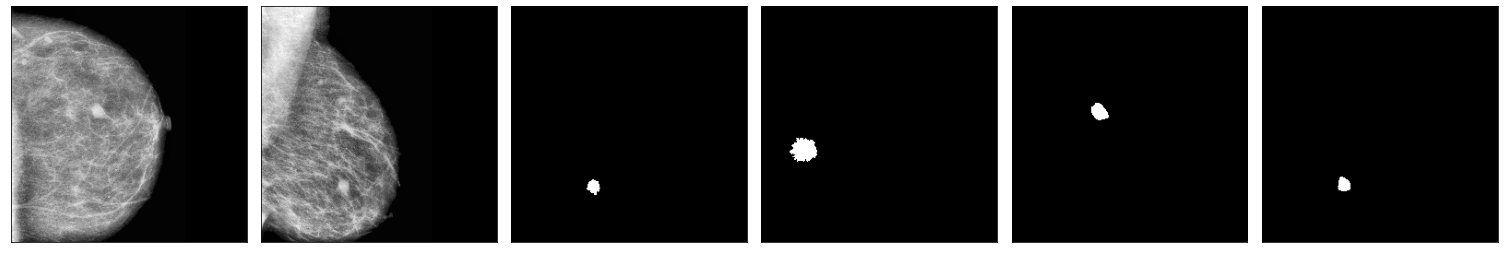

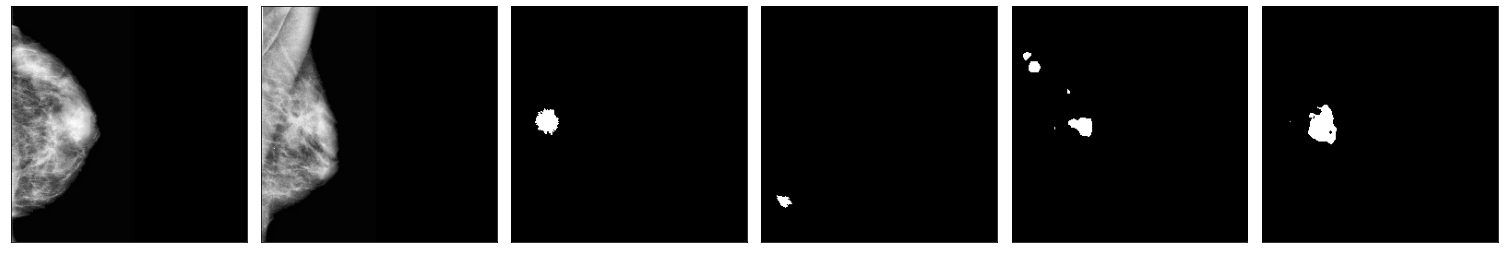

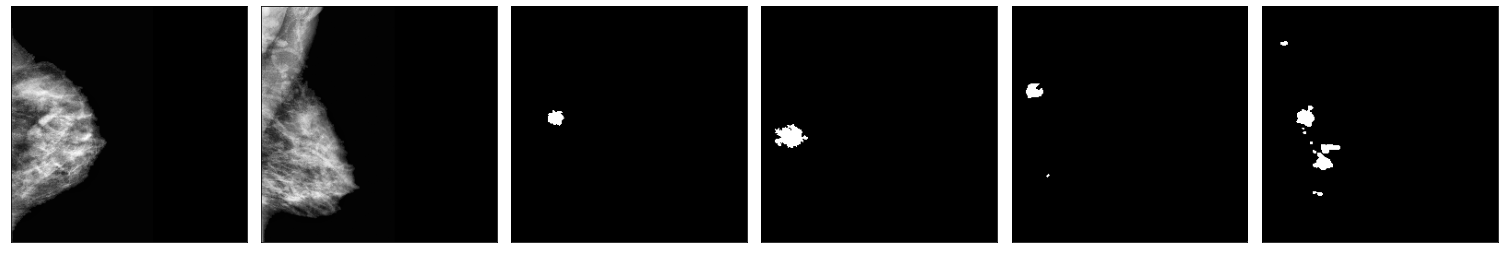

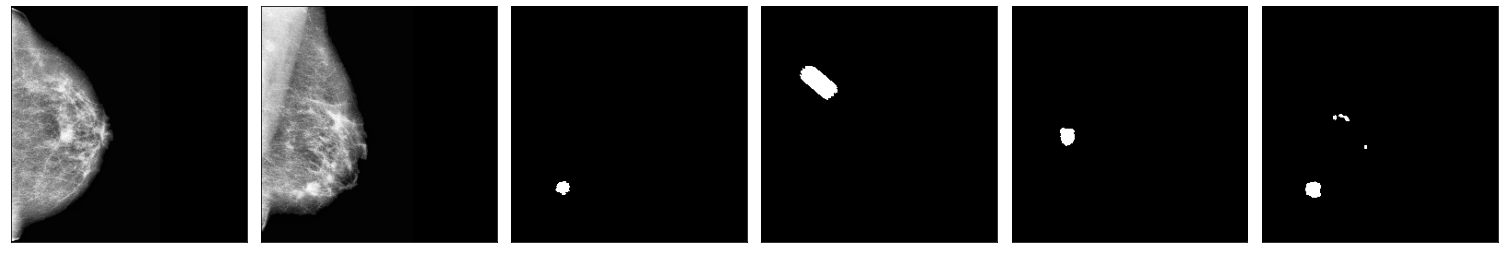

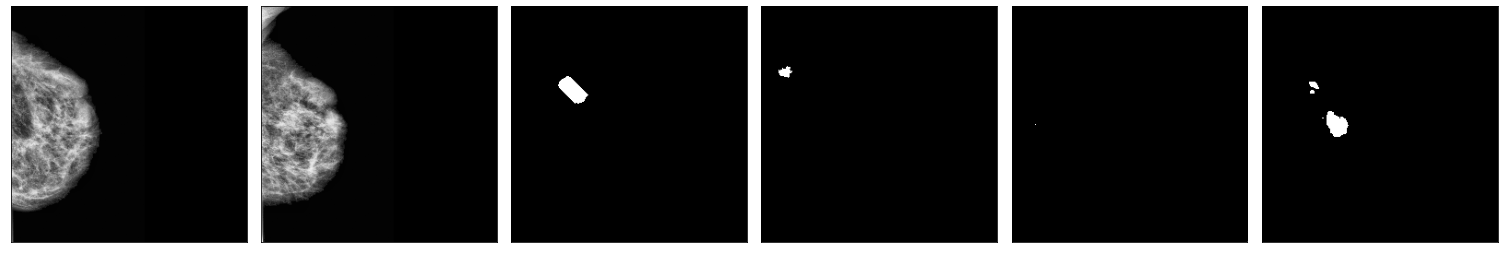

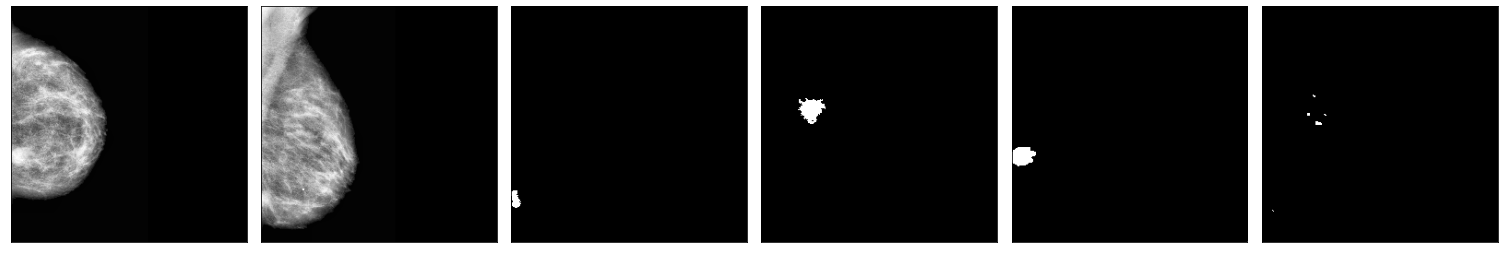

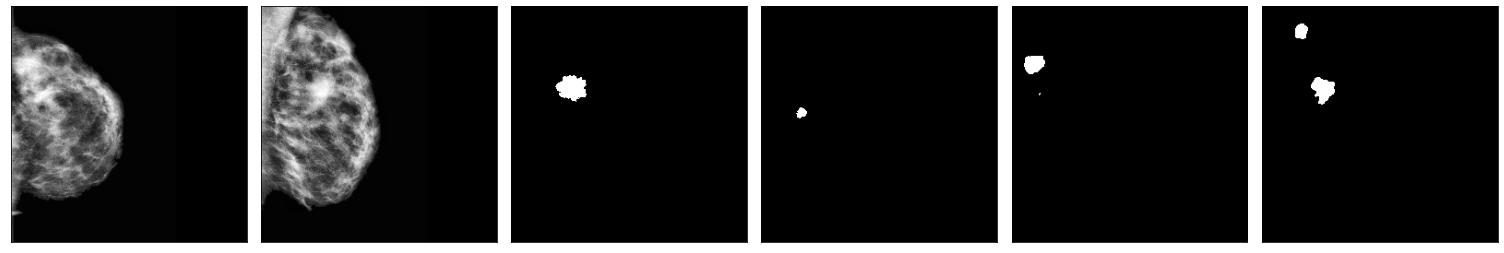

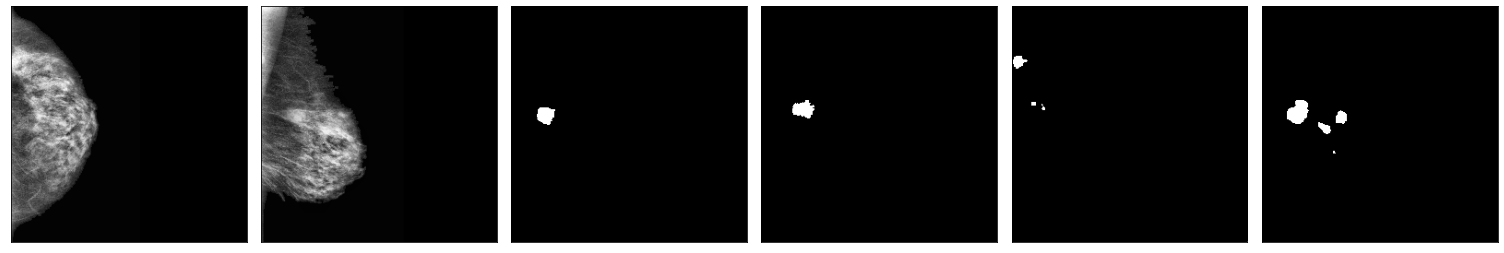

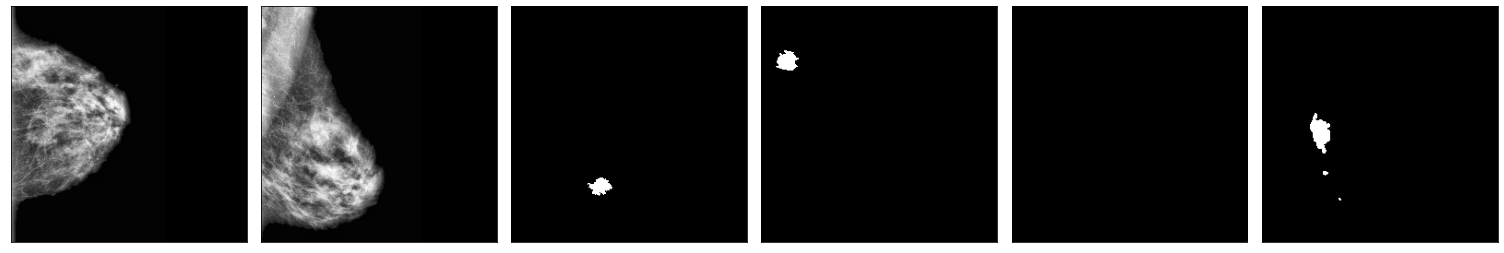

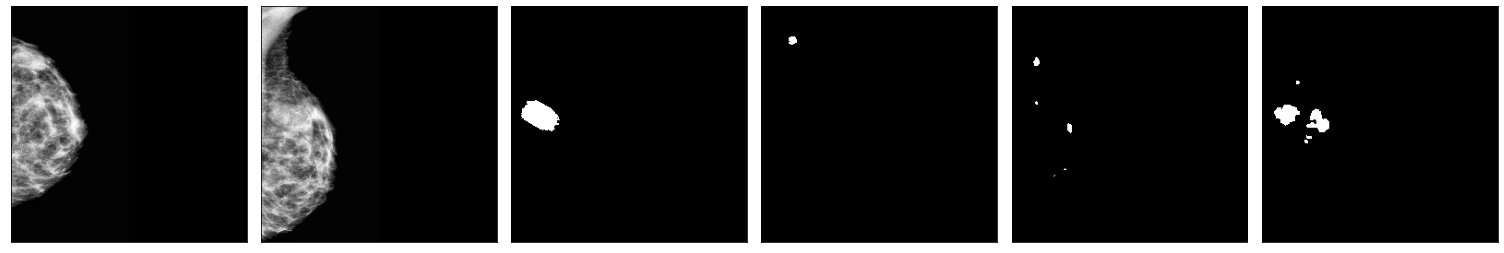

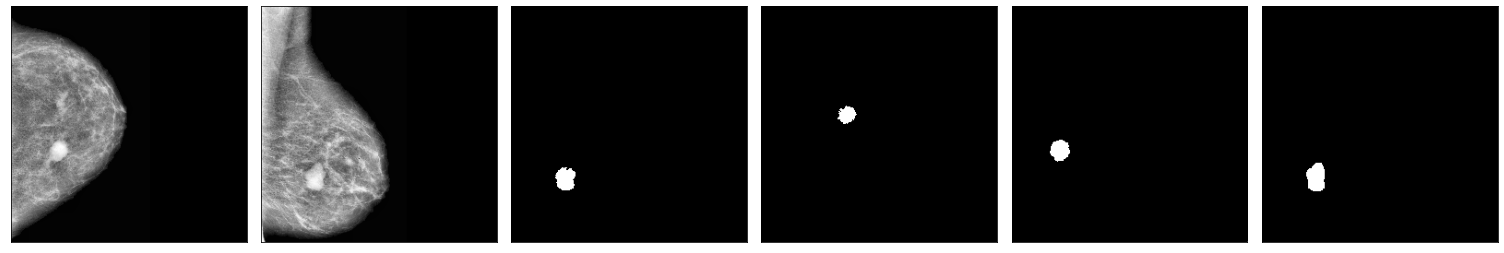

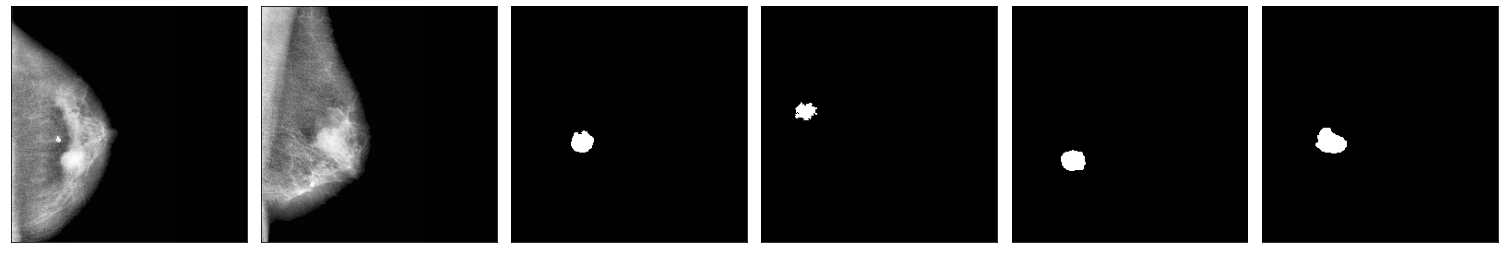

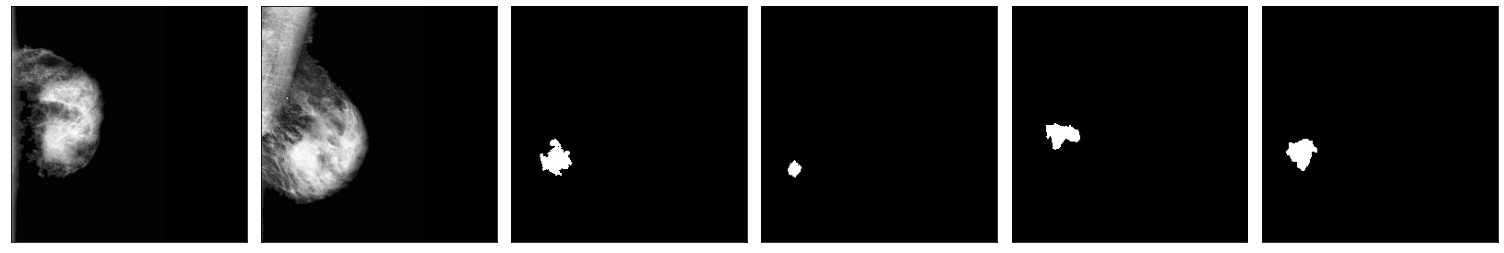

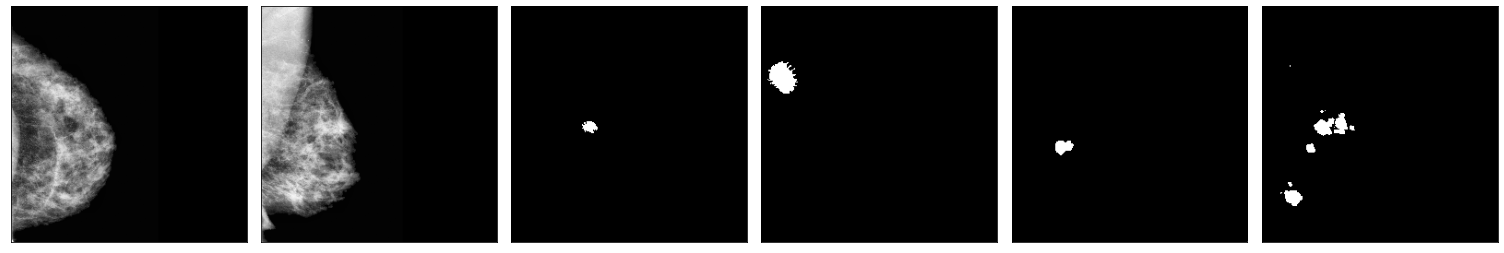

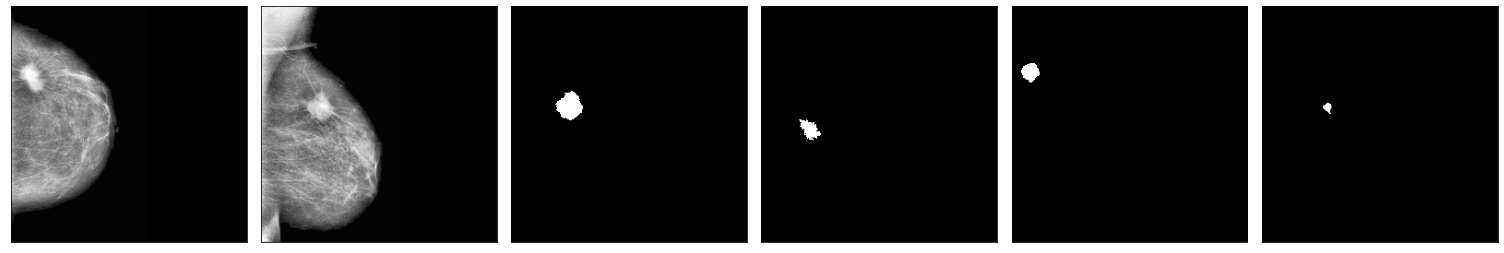

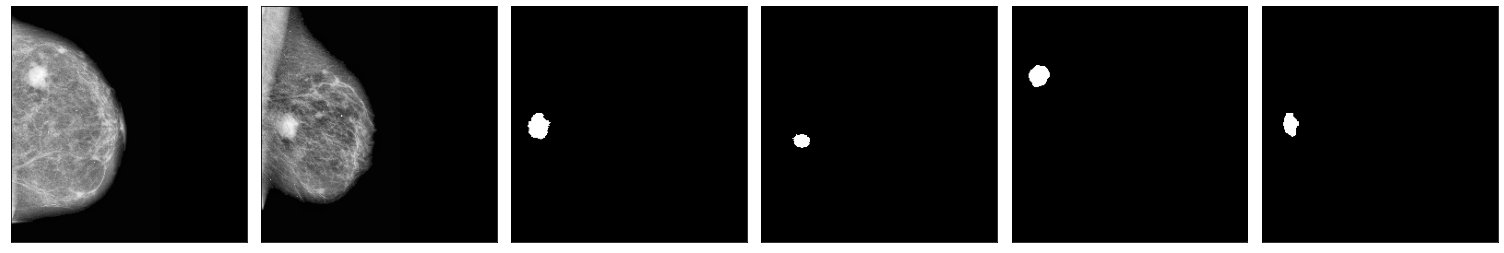

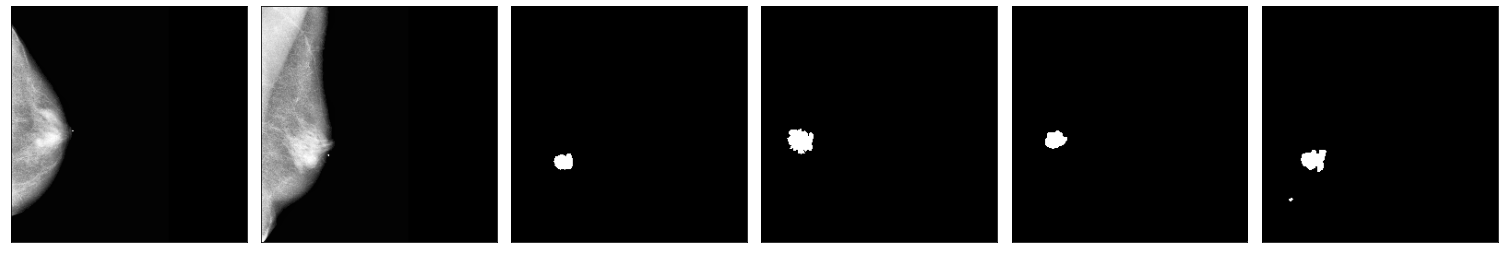

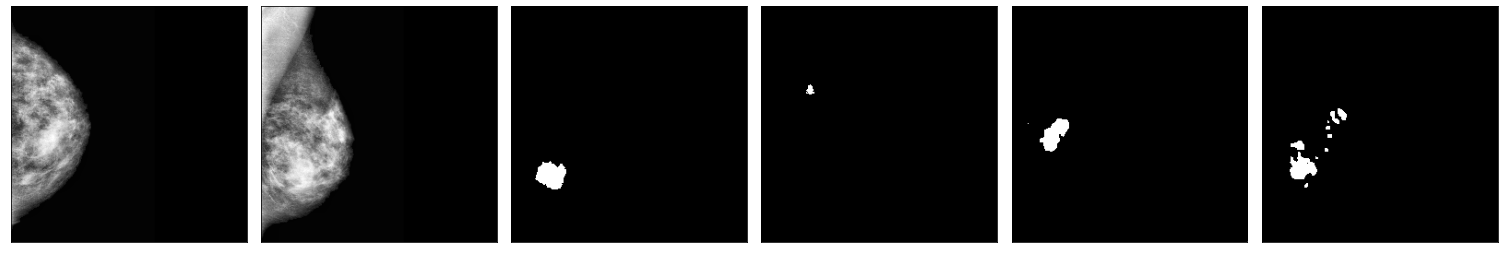

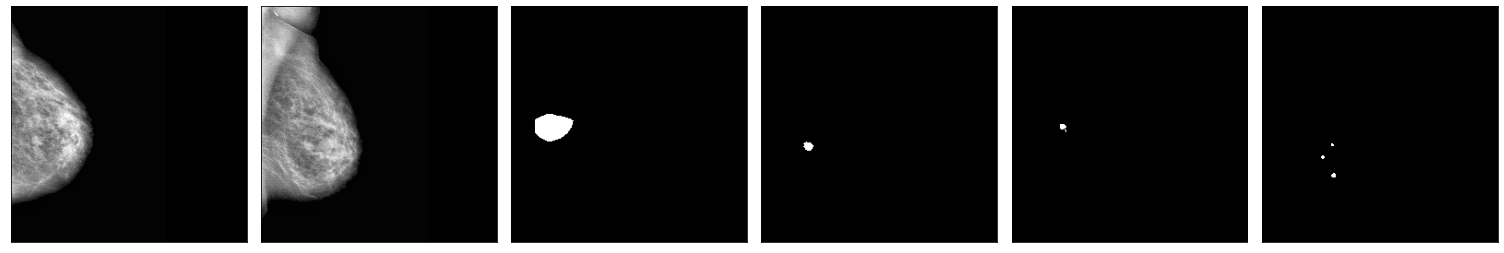

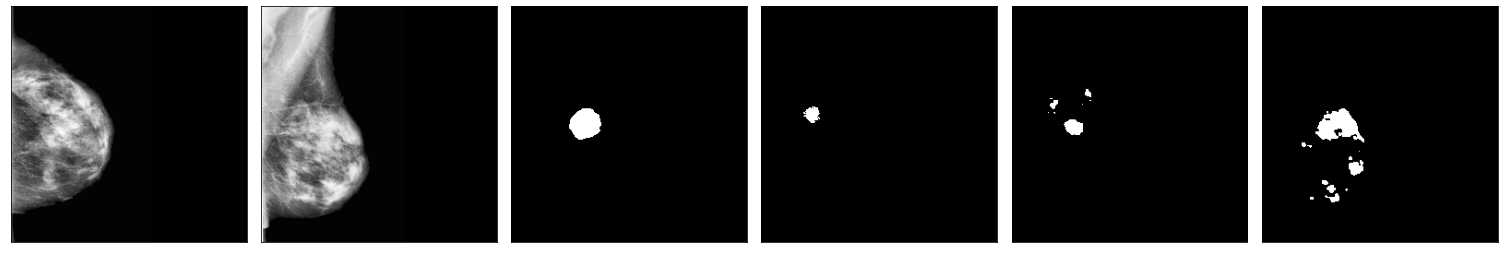

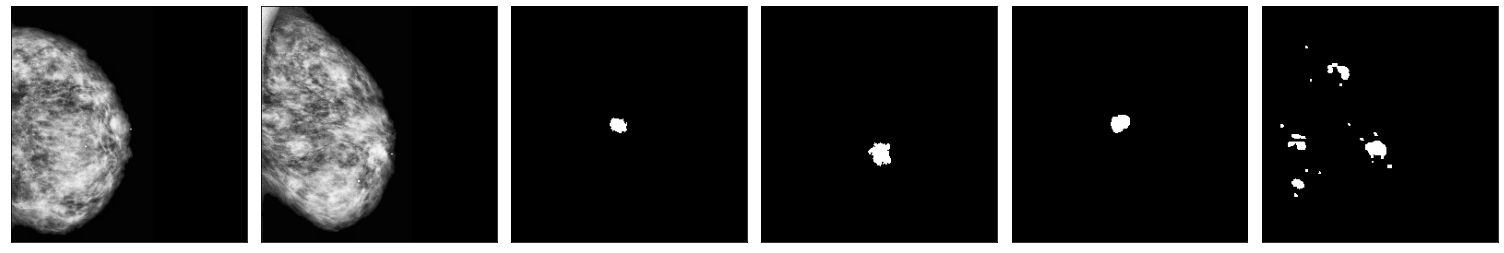

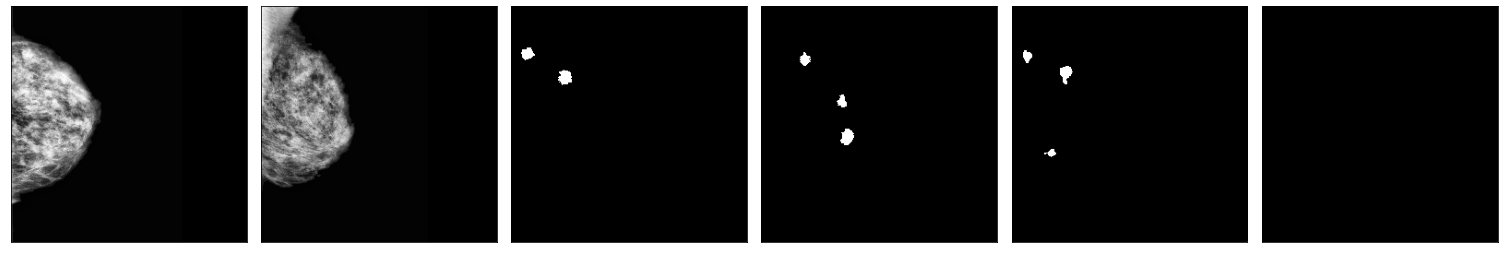

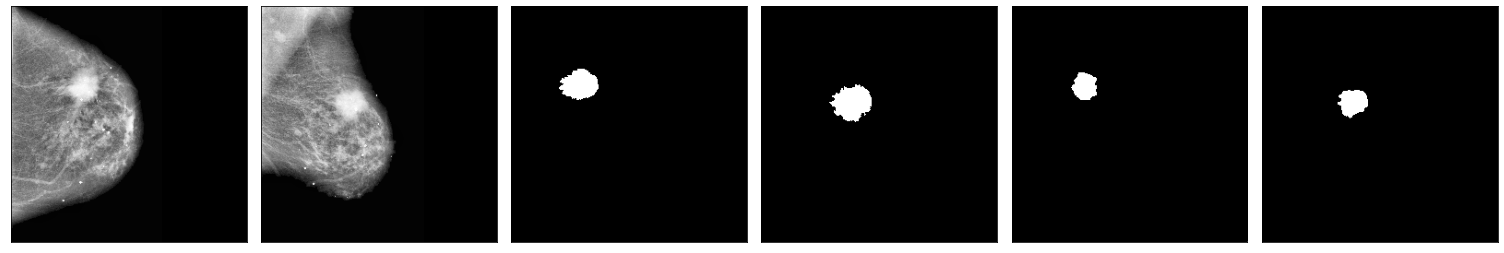

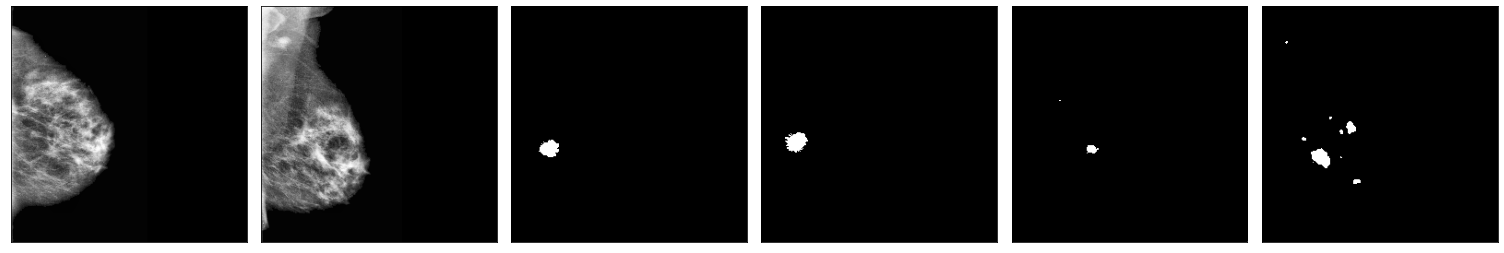

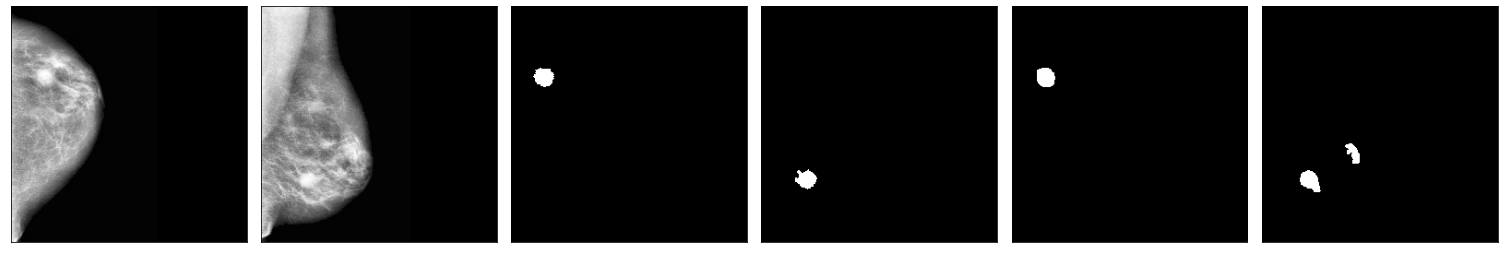

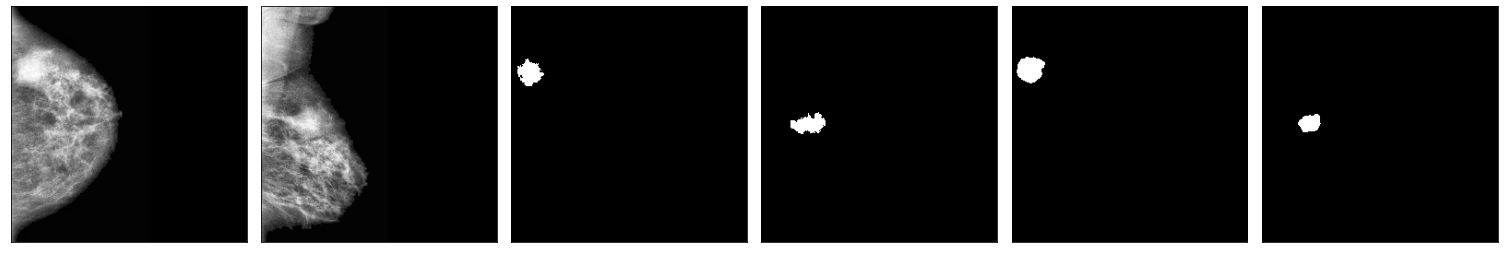

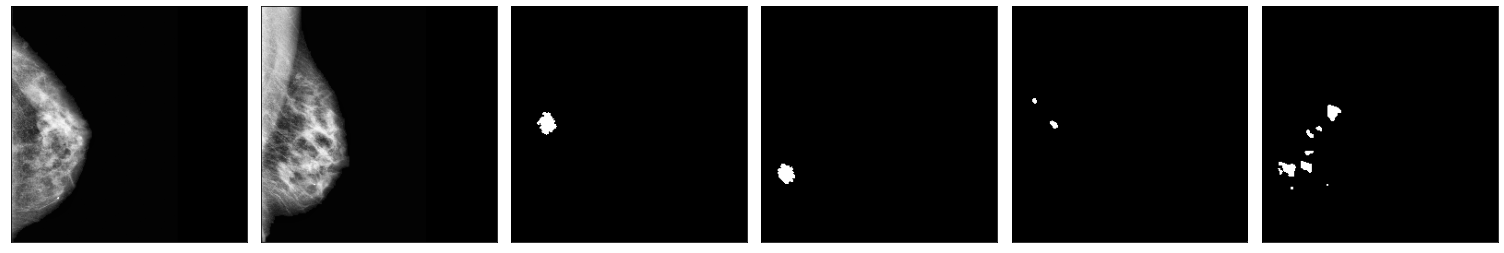

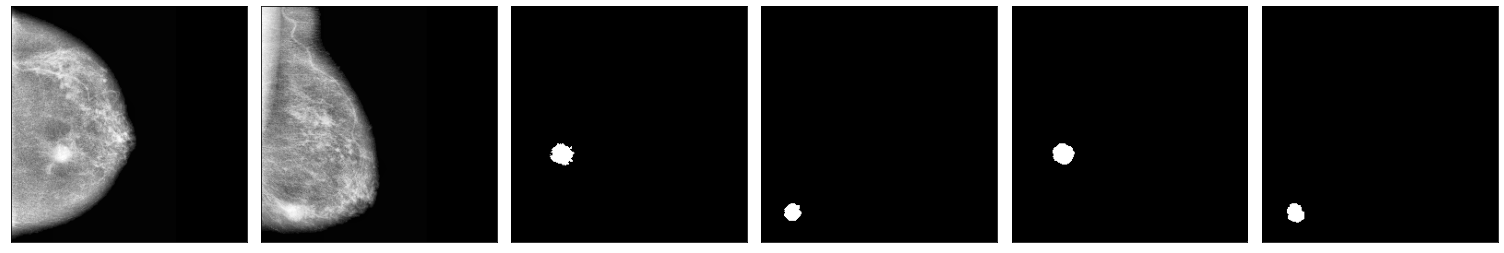

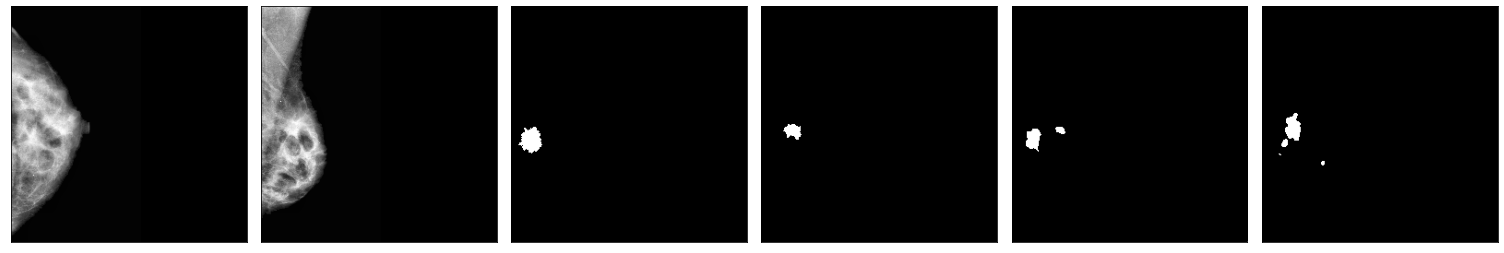

In [ ]:
dice_score_arr_test=[]
iou_score_arr_test = []
haus_score_arr_test = []

for i in range(len(X_test)):

    # =======================================
    #  Save predicted numpy arrays as images
    # =======================================
    # predicted_outputs = unet_cvam.predict(X_test[i])

    predicted_outputs_cc = predicted_outputs[i][:, :, 0]
    predicted_outputs_mlo = predicted_outputs[i][:, :, 1]

    predicted_outputs_cc = (predicted_outputs_cc > 0.5 ) * 1.0
    predicted_outputs_mlo = (predicted_outputs_mlo > 0.5 ) * 1.0

    original_input_cc = X_test[i][:, :, : 3]
    original_input_mlo = X_test[i][:, :, 3 :]

    original_output_cc = y_test[i][:, :, 0]
    original_output_mlo = y_test[i][:, :, 1]

    # Get patient ID
    # filename = os.path.basename(test_x[i])
    # patientID = filename.replace("___PRE" + extension, "")

    # Get save path
    # filename_new_1 = patientID + "___PREDICTED" + extension
    # filename_new_3 = patientID + "___PREDICTED_ALL" + extension
    #save_path_1 = os.path.join(save_predicted, "predmask_only", filename_new_1)
    #save_path_3 = os.path.join(
    #    save_predicted, "full_truemask_predmask", filename_new_3
    #)

    # Plot image and save
    fig, ax = plt.subplots(nrows=1, ncols=6, figsize=(21, 7))
    ax[0].imshow(original_input_cc, cmap="gray")
    ax[1].imshow(original_input_mlo, cmap="gray")
    ax[2].imshow(original_output_cc, cmap="gray")
    ax[3].imshow(original_output_mlo, cmap="gray")
    ax[4].imshow(predicted_outputs_cc * 255, cmap="gray")
    ax[5].imshow(predicted_outputs_mlo * 255, cmap="gray")

    # print(predicted_outputs[i].min(), predicted_outputs[i].max())
    # temp_dice = dice(predicted_outputs_squeezed[i], test_masks_squeezed[i], k = 1)
    # temp_iou = iou(predicted_outputs_squeezed[i], test_masks_squeezed[i])
    # haus_temp = directed_hausdorff(test_masks_squeezed[i], predicted_outputs_squeezed[i])
    # dice_score_arr_test.append(temp_dice)
    # iou_score_arr_test.append(temp_iou)
    # haus_score_arr_test.append(haus_temp[0])
    # print("Dice ", temp_dice)
    # print("Jaccard ", temp_iou)
    # print("Hausdorff: ", haus_temp)

    # # Set title and remove axes
    # patientID_noFULL = patientID.replace("_FULL", "")
    # ax[0].set_title(f"{patientID_noFULL} - Full scan")
    # ax[1].set_title(f"{patientID_noFULL} - Ground truth mask")
    # ax[2].set_title(f"{patientID_noFULL} - Predicted mask")
    ax[0].get_xaxis().set_visible(False)
    ax[0].get_yaxis().set_visible(False)
    ax[1].get_xaxis().set_visible(False)
    ax[1].get_yaxis().set_visible(False)
    ax[2].get_xaxis().set_visible(False)
    ax[2].get_yaxis().set_visible(False)
    ax[3].get_xaxis().set_visible(False)
    ax[3].get_yaxis().set_visible(False)
    ax[4].get_xaxis().set_visible(False)
    ax[4].get_yaxis().set_visible(False)
    ax[5].get_xaxis().set_visible(False)
    ax[5].get_yaxis().set_visible(False)
    plt.tight_layout()
    plt.show()

In [ ]:
a

### CVAM - Attention UNet

In [ ]:
def unet_with_cvam():
    inputs = Input((target_size, target_size, 6))

    ## Splitting the inputs into cc and mlo

    input_cc = inputs[:, :, :, : 3]
    input_mlo = inputs[:, :, :, 3 :]

    ## 1st Layer

    conv1_cc = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer= tf.keras.regularizers.l2(l=0.001))(input_cc)
    conv1_cc = BatchNormalization()(conv1_cc)
    conv1_cc = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer= tf.keras.regularizers.l2(l=0.001))(conv1_cc)
    conv1_cc = BatchNormalization()(conv1_cc)

    conv1_mlo = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer= tf.keras.regularizers.l2(l=0.001))(input_mlo)
    conv1_mlo = BatchNormalization()(conv1_mlo)
    conv1_mlo = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer= tf.keras.regularizers.l2(l=0.001))(conv1_mlo)
    conv1_mlo = BatchNormalization()(conv1_mlo)

    pool1_cc = MaxPooling2D((2,2), padding='same')(conv1_cc)
    pool1_mlo = MaxPooling2D((2,2), padding='same')(conv1_mlo)

    ## 2nd Layer

    conv2_cc = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer= tf.keras.regularizers.l2(l=0.001))(pool1_cc)
    conv2_cc = BatchNormalization()(conv2_cc)
    conv2_cc = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer= tf.keras.regularizers.l2(l=0.001))(conv2_cc)
    conv2_cc = BatchNormalization()(conv2_cc)

    conv2_mlo = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer= tf.keras.regularizers.l2(l=0.001))(pool1_mlo)
    conv2_mlo = BatchNormalization()(conv2_mlo)
    conv2_mlo = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer= tf.keras.regularizers.l2(l=0.001))(conv2_mlo)
    conv2_mlo = BatchNormalization()(conv2_mlo)

    # conv2_cc, conv2_mlo = cvamBlock(conv2_cc, conv2_mlo)

    pool2_cc = MaxPooling2D((2,2), padding='same')(conv2_cc)
    pool2_mlo = MaxPooling2D((2,2), padding='same')(conv2_mlo)

    ## 3rd Layer

    conv3_cc = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer= tf.keras.regularizers.l2(l=0.001))(pool2_cc)
    conv3_cc = BatchNormalization()(conv3_cc)
    conv3_cc = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer= tf.keras.regularizers.l2(l=0.001))(conv3_cc)
    conv3_cc = BatchNormalization()(conv3_cc)

    conv3_mlo = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer= tf.keras.regularizers.l2(l=0.001))(pool2_mlo)
    conv3_mlo = BatchNormalization()(conv3_mlo)
    conv3_mlo = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer= tf.keras.regularizers.l2(l=0.001))(conv3_mlo)
    conv3_mlo = BatchNormalization()(conv3_mlo)

    # conv3_cc, conv3_mlo = cvamBlock(conv3_cc, conv3_mlo)

    pool3_cc = MaxPooling2D((2,2), padding='same')(conv3_cc)
    pool3_mlo = MaxPooling2D((2,2), padding='same')(conv3_mlo)


    ## 4th Layer

    conv4_cc = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer= tf.keras.regularizers.l2(l=0.001))(pool3_cc)
    conv4_cc = BatchNormalization()(conv4_cc)
    conv4_cc = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer= tf.keras.regularizers.l2(l=0.001))(conv4_cc)
    conv4_cc = BatchNormalization()(conv4_cc)

    conv4_mlo = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer= tf.keras.regularizers.l2(l=0.001))(pool3_mlo)
    conv4_mlo = BatchNormalization()(conv4_mlo)
    conv4_mlo = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer= tf.keras.regularizers.l2(l=0.001))(conv4_mlo)
    conv4_mlo = BatchNormalization()(conv4_mlo)

    # conv4_cc, conv4_mlo = cvamBlock(conv4_cc, conv4_mlo)

    pool4_cc = MaxPooling2D((2,2), padding='same')(conv4_cc)
    pool4_mlo = MaxPooling2D((2,2), padding='same')(conv4_mlo)

    ## 5th Layer

    conv5_cc = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer= tf.keras.regularizers.l2(l=0.001))(pool4_cc)
    conv5_cc = BatchNormalization()(conv5_cc)
    conv5_cc = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer= tf.keras.regularizers.l2(l=0.001))(conv5_cc)
    conv5_cc = BatchNormalization()(conv5_cc)
 
    conv5_mlo = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer= tf.keras.regularizers.l2(l=0.001))(pool4_mlo)
    conv5_mlo = BatchNormalization()(conv5_mlo)
    conv5_mlo = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer= tf.keras.regularizers.l2(l=0.001))(conv5_mlo)
    conv5_mlo = BatchNormalization()(conv5_mlo)

    ## 6th Layer

    up6_cc = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same', kernel_regularizer= tf.keras.regularizers.l2(l=0.001))(conv5_cc), conv4_cc], axis=3)
    conv6_cc = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer= tf.keras.regularizers.l2(l=0.001))(up6_cc)
    conv6_cc = BatchNormalization()(conv6_cc)
    conv6_cc = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer= tf.keras.regularizers.l2(l=0.001))(conv6_cc)
    conv6_cc = BatchNormalization()(conv6_cc)

    up6_mlo = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same', kernel_regularizer= tf.keras.regularizers.l2(l=0.001))(conv5_mlo), conv4_mlo], axis=3)
    conv6_mlo = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer= tf.keras.regularizers.l2(l=0.001))(up6_mlo)
    conv6_mlo = BatchNormalization()(conv6_mlo)
    conv6_mlo = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer= tf.keras.regularizers.l2(l=0.001))(conv6_mlo)
    conv6_mlo = BatchNormalization()(conv6_mlo)

    # conv6_cc, conv6_mlo = cvamBlock(conv6_cc, conv6_mlo)

    ## 7th Layer
    
    up7_cc = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same', kernel_regularizer= tf.keras.regularizers.l2(l=0.001))(conv6_cc), conv3_cc], axis=3)
    conv7_cc = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer= tf.keras.regularizers.l2(l=0.001))(up7_cc)
    conv7_cc = BatchNormalization()(conv7_cc)
    conv7_cc = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer= tf.keras.regularizers.l2(l=0.001))(conv7_cc)
    conv7_cc = BatchNormalization()(conv7_cc)

    up7_mlo = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same', kernel_regularizer= tf.keras.regularizers.l2(l=0.001))(conv6_mlo), conv3_mlo], axis=3)
    conv7_mlo = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer= tf.keras.regularizers.l2(l=0.001))(up7_mlo)
    conv7_mlo = BatchNormalization()(conv7_mlo)
    conv7_mlo = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer= tf.keras.regularizers.l2(l=0.001))(conv7_mlo)
    conv7_mlo = BatchNormalization()(conv7_mlo)

    # conv7_cc, conv7_mlo = cvamBlock(conv7_cc, conv7_mlo)

    ## 8th Layer

    up8_cc = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same', kernel_regularizer= tf.keras.regularizers.l2(l=0.001))(conv7_cc), conv2_cc], axis=3)
    conv8_cc = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer= tf.keras.regularizers.l2(l=0.001))(up8_cc)
    conv8_cc = BatchNormalization()(conv8_cc)
    conv8_cc = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer= tf.keras.regularizers.l2(l=0.001))(conv8_cc)
    conv8_cc = BatchNormalization()(conv8_cc)

    up8_mlo = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same', kernel_regularizer= tf.keras.regularizers.l2(l=0.001))(conv7_mlo), conv2_mlo], axis=3)
    conv8_mlo = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer= tf.keras.regularizers.l2(l=0.001))(up8_mlo)
    conv8_mlo = BatchNormalization()(conv8_mlo)
    conv8_mlo = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer= tf.keras.regularizers.l2(l=0.001))(conv8_mlo)
    conv8_mlo = BatchNormalization()(conv8_mlo)

    # conv8_cc, conv8_mlo = cvamBlock(conv8_cc, conv8_mlo)

    ## 9th Layer
    
    up9_cc = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same', kernel_regularizer= tf.keras.regularizers.l2(l=0.001))(conv8_cc), conv1_cc], axis=3)
    conv9_cc = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer= tf.keras.regularizers.l2(l=0.001))(up9_cc)
    conv9_cc = BatchNormalization()(conv9_cc)
    conv9_cc = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer= tf.keras.regularizers.l2(l=0.001))(conv9_cc)
    conv9_cc = BatchNormalization()(conv9_cc)

    up9_mlo = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same', kernel_regularizer= tf.keras.regularizers.l2(l=0.001))(conv8_mlo), conv1_mlo], axis=3)
    conv9_mlo = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer= tf.keras.regularizers.l2(l=0.001))(up9_mlo)
    conv9_mlo = BatchNormalization()(conv9_mlo)
    conv9_mlo = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer= tf.keras.regularizers.l2(l=0.001))(conv9_mlo)
    conv9_mlo = BatchNormalization()(conv9_mlo)

    ## Final Layer
        
    conv10_cc = Conv2D(1, (1, 1), activation='sigmoid')(conv9_cc)
    conv10_mlo = Conv2D(1, (1, 1), activation='sigmoid')(conv9_mlo)

    ## Stacking the final masks on top of another
    conv10 = concatenate([conv10_cc, conv10_mlo], axis= -1)


    model = Model(inputs=[inputs], outputs=[conv10])
    model.compile(optimizer = Adam(1e-3), loss = 'binary_crossentropy', metrics = [dice_coef, jacard, 'accuracy'])
    model.summary()
    return model